# Basic Imports

In [1]:
from __future__ import print_function, division
import logging
reload(logging)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs).03d %(name)s %(message)s",
    datefmt='%Y-%m-%dT%H:%M:%S'
)

In [2]:
%matplotlib inline

import pandas
import numpy
from matplotlib import pylab
import seaborn

import ipywidgets as ipyw

import IPython
from IPython.display import display

In [3]:
import itertools
import toolz.dicttoolz
from toolz.dicttoolz import merge

In [4]:
!git show --oneline -s HEAD

7c1d73c Add README, remove legacy code components.


In [5]:
import jug
jug.init("replicate_analysis.py")
import replicate_analysis

In [6]:
def pred_dist_delta(counts, preds):
    rf = pandas.DataFrame(index=counts.index)
    
    for g in preds:
        obs_dist = counts["counts%s" % g] / counts["counts%s" % g].sum()
        pred_dist = preds[g]["selection_dist"] / preds[g]["selection_dist"].sum()

        lobs_dist = numpy.log(obs_dist).clip(-9, None)
        lpred_dist = numpy.log(pred_dist).clip(-9, None)
        rf["l_dist_delta_%s" % g] = lobs_dist - lpred_dist
        rf["l_dist_delta_%s" % g][obs_dist == 0] = numpy.nan
    return rf

In [7]:
import scipy.stats
from scipy.stats import pearsonr
import sklearn.metrics
from sklearn.metrics import mean_squared_error

model_param_evaluations = {
    "pearsonr" : lambda x1, x2: scipy.stats.pearsonr(x1, x2)[0],
    "neg_mse" : lambda x1, x2: -mean_squared_error(x1, x2),
    "neg_outlier_mse" : lambda x1, x2: (
        -numpy.mean(numpy.clip(numpy.abs(x1 - x2) - 1, 0, None) ** 2))
}

In [8]:
from replicate_analysis import replicate_pairs, parameter_sets, model_results, data
model_results = jug.value(model_results)

In [9]:
fit_summaries = dict()

for k, results in model_results.items():
    ds, _ = k
    counts = data.counts[ds].copy()
    params = results["params"]
    preds = results["predictions"]

    sf = counts[["name"]].copy()
    sf["ec50"] = params["sel_ec50"]
    pdd = pred_dist_delta(counts, preds)

    fit_summaries[k] = pandas.concat((sf, pdd), axis=1)
        

In [10]:
replicate_summary_frames = {
    (d, p) : 
    pandas.merge(fit_summaries[(a, p)], fit_summaries[(b, p)], how="inner", on="name")
    for d, (a, b) in replicate_pairs.items()
    for p in zip(*fit_summaries)[1]
}

In [11]:
from grocklin_fits import fits as grocklin_fit_results
grocklin_fit_summaries = dict()

for n, fr in grocklin_fit_results.items():
    preds = {
        int(c[-1]) : { "selection_dist" : fr[c].values}
        for c in fr.columns if c.startswith("pop_fraction")
    }
    
    sf = fr[["name", "ec50"]].copy()
    pdd = pred_dist_delta(fr, preds)
    
    grocklin_fit_summaries[(n, "grocklin")] = pandas.concat((sf, pdd), axis=1)

In [12]:
grocklin_replicate_summary_frames = {
    (d, p) : 
    pandas.merge(grocklin_fit_summaries[(a, p)], grocklin_fit_summaries[(b, p)], how="inner", on="name")
    for d, (a, b) in replicate_pairs.items()
    for p in zip(*grocklin_fit_summaries)[1]
}

# Evaluation Overview

Adding evaluation via existing `model_param_evaluations` metrics, which measure concordance of replicate experiements.

Adding evaluation of model quality via sort-of-hacky mean-square-log-delta between observed and predicted population distributions. `ms_log_d` is a per-sort-round evaluation and `sum_ms_log_d` is a sum of per-sort-round evaluations.

In [13]:
eval_records = [
    merge(
        dict(dataset=dataset, param_set=param_set),
        {
            e : ef(sf["ec50_x"], sf["ec50_y"])
            for e, ef in model_param_evaluations.items()
        },
        dict(param_set),
        { 
            "fit_" + v : model_results[(dataset, param_set)]["params"].get(v, None)
            for v in ("min_selection_mass",)
        },
        { "sel_k" : float(model_results[(dataset, param_set)]["params"]["sel_k"]) },
        {
            "ms_log_d_%s" % g : numpy.mean([
                numpy.nanmean(numpy.square(fit_summaries[(ds, param_set)]["l_dist_delta_%s" % g]))
                for ds in replicate_pairs[dataset]])
            for g in range(1, 7)
        },
    )
    for (dataset, param_set), sf in replicate_summary_frames.items()
]

grocklin_eval_records = [
    merge(
        dict(dataset=dataset, param_set=param_set),
        {
            e : ef(sf["ec50_x"], sf["ec50_y"])
            for e, ef in model_param_evaluations.items()
        },
        {"min_selection_mass" : "grocklin"},
        {
            "ms_log_d_%s" % g : numpy.mean([
                numpy.nanmean(numpy.square(grocklin_fit_summaries[(ds, param_set)]["l_dist_delta_%s" % g]))
                for ds in replicate_pairs[dataset]])
            for g in range(1, 7)
        },
    )
    for (dataset, param_set), sf in grocklin_replicate_summary_frames.items()
]


eval_records = pandas.DataFrame.from_records(eval_records + grocklin_eval_records)

eval_records["neg_sum_ms_log_d"] = -eval_records[["ms_log_d_%s" % i for i in range(1, 7)]].sum(axis=1)

In [14]:
eval_records

,dataset,fit_min_selection_mass,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
0,rd3_chymo,None,1e-05,0.016052,0.026609,0.044510,0.710797,0.821934,2.363822,-0.640807,-0.167101,"((response_fn, NormalSpaceErfResponse), (min_s...",0.843563,NormalSpaceErfResponse,3.728371,-3.983724
1,rd2_chymo,None,1e-07,0.071513,0.094578,0.047153,0.368778,0.404438,0.560002,-1.873912,-0.741271,"((min_selection_mass, 1e-07), (response_fn, No...",0.549816,NormalSpaceErfResponse,1.498800,-1.546462
2,rd3_tryp,None,5e-07,0.013072,0.016708,0.045557,0.065184,0.044383,0.110060,-0.456436,-0.080085,"((min_selection_mass, 5e-07), (response_fn, No...",0.883675,NormalSpaceErfResponse,6.499980,-0.294964
3,rd2_chymo,None,False,0.073982,0.101331,0.055246,0.400453,0.381422,0.565567,-2.034179,-0.849854,"((response_fn, NormalSpaceErfResponse), (min_s...",0.542697,NormalSpaceErfResponse,1.498344,-1.578002
4,rd2_chymo,None,1e-05,0.062219,0.088367,0.053300,0.484734,0.571838,1.291748,-2.286442,-0.965717,"((response_fn, NormalSpaceErfResponse), (min_s...",0.540012,NormalSpaceErfResponse,1.499977,-2.552206
5,rd2_chymo,None,5e-07,0.070052,0.091804,0.044453,0.343324,0.427390,0.610055,-1.399504,-0.476442,"((min_selection_mass, 5e-07), (response_fn, No...",0.595339,NormalSpaceErfResponse,1.499004,-1.587078
6,rd3_tryp,None,1e-05,0.010138,0.014417,0.048612,0.068457,0.250852,0.820930,-0.566457,-0.117826,"((response_fn, NormalSpaceErfResponse), (min_s...",0.869000,NormalSpaceErfResponse,6.500002,-1.213406
7,rd2_tryp,None,1e-06,0.034387,0.060647,0.056069,0.083400,0.055521,4.204063,-1.320959,-0.327464,"((min_selection_mass, 1e-06), (response_fn, No...",0.517265,NormalSpaceErfResponse,5.144419,-4.494086
8,rd3_chymo,None,5e-07,0.019080,0.032020,0.053455,0.338164,0.466441,1.651679,-0.335330,-0.061740,"((min_selection_mass, 5e-07), (response_fn, No...",0.890119,NormalSpaceErfResponse,2.199990,-2.560840
9,rd2_chymo,None,1e-06,0.069286,0.090447,0.043526,0.334904,0.441589,0.665746,-1.927253,-0.726542,"((min_selection_mass, 1e-06), (response_fn, No...",0.557168,NormalSpaceErfResponse,1.499115,-1.645498


# General Conclusions

There is no single conclusive "winner" in the metrics we're considering for datasest quality and replicate concordance. In general, the low-value constant homogenous leak model (1e-6) is best followed by the tuned ("global") leak rate. The constant leak model outperforms (slightly) when assessing by replicate pearsonr.

# Result ranks by measure.

Table of model ranking by measure & dataset.

In [15]:
measures = ["pearsonr", "neg_sum_ms_log_d"]
ranks = { v : [] for v in set(eval_records["min_selection_mass"])}

cols = []
for measure in measures:
    for ds, f in eval_records.groupby("dataset"):
        cols.append((measure, ds))
        
        mrank = f.sort_values(measure, ascending=False).reset_index(drop=True)["min_selection_mass"]
        for m, r in zip(mrank, mrank.index):
            ranks[m].append(r)
            
display({ m : sorted(vs) for m, vs in ranks.items() })

display({ m : numpy.mean(vs) for m, vs in ranks.items() })

display(pandas.DataFrame(data=ranks.values(), index=ranks.keys(), columns=cols)[sorted(cols)])

{False: [0, 1, 1, 1, 4, 6, 7, 7],
 1e-07: [0, 0, 1, 2, 3, 3, 4, 5],
 5e-07: [0, 1, 1, 2, 2, 2, 2, 3],
 1e-06: [0, 1, 2, 3, 3, 5, 6, 6],
 1e-05: [4, 6, 7, 7, 7, 7, 7, 7],
 'global': [2, 3, 3, 4, 4, 5, 5, 6],
 'grocklin': [0, 0, 1, 2, 3, 4, 4, 5],
 'per_selection': [0, 4, 5, 5, 5, 6, 6, 6]}

{False: 3.375,
 1e-07: 2.25,
 5e-07: 1.625,
 1e-06: 3.25,
 1e-05: 6.5,
 'global': 4.0,
 'grocklin': 2.375,
 'per_selection': 4.625}

,"(neg_sum_ms_log_d, rd2_chymo)","(neg_sum_ms_log_d, rd2_tryp)","(neg_sum_ms_log_d, rd3_chymo)","(neg_sum_ms_log_d, rd3_tryp)","(pearsonr, rd2_chymo)","(pearsonr, rd2_tryp)","(pearsonr, rd3_chymo)","(pearsonr, rd3_tryp)"
False,1,0,1,1,6,7,4,7
5e-07,2,2,3,2,0,1,1,2
1e-05,7,7,7,7,7,6,7,4
1e-07,0,1,2,0,4,5,3,3
global,5,3,4,4,2,3,5,6
1e-06,3,5,6,6,3,0,2,1
grocklin,4,4,5,3,1,2,0,0
per_selection,6,6,0,5,5,4,6,5


# Model performance

Model performance on given metrics. `delta` column shows metric delta from maximum within the dataset.

In [16]:
measures = ["neg_outlier_mse", "pearsonr", "neg_sum_ms_log_d"]

for param in ("min_selection_mass",):
    rpt = eval_records.groupby(("dataset", param))[measures].max()
    delta = (rpt.groupby(rpt.index.get_level_values("dataset")).max() - rpt).rename(columns=lambda c: "delta_" + c)
    
    display(
        pandas.concat([rpt, delta], axis=1)
        .applymap( lambda v: "%.2f" % v)
    )

neg_outlier_mse pearsonr neg_sum_ms_log_d  \
dataset   min_selection_mass                                             
rd2_chymo False                        -0.85     0.54            -1.58   
          1e-07                        -0.74     0.55            -1.55   
          5e-07                        -0.48     0.60            -1.59   
          1e-06                        -0.73     0.56            -1.65   
          1e-05                        -0.97     0.54            -2.55   
          global                       -0.57     0.58            -1.68   
          grocklin                     -0.69     0.58            -1.67   
          per_selection                -0.86     0.55            -2.26   
rd2_tryp  False                        -0.90     0.38            -4.10   
          1e-07                        -0.83     0.38            -4.18   
          5e-07                        -0.44     0.49            -4.25   
          1e-06                        -0.33     0.52            -4.49   
          1e-05                        -1.12     0.38            -5.39   
          global                       -0.67     0.41            -4.31   
          grocklin                     -0.57     0.45            -4.46   
          per_selection                -0.78     0.39            -4.91   
rd3_chymo False                        -0.07     0.86            -2.44   
          1e-07                        -0.07     0.88            -2.45   
          5e-07                        -0.06     0.89            -2.56   
          1e-06                        -0.07     0.88            -2.77   
          1e-05                        -0.17     0.84            -3.98   
          global                       -0.08     0.86            -2.64   
          grocklin                     -0.07     0.89            -2.75   
          per_selection                -0.08     0.86            -2.42   
rd3_tryp  False                        -0.09     0.84            -0.29   
          1e-07                        -0.05     0.88            -0.27   
          5e-07                        -0.08     0.88            -0.29   
          1e-06                        -0.06     0.89            -0.35   
          1e-05                        -0.12     0.87            -1.21   
          global                       -0.08     0.86            -0.32   
          grocklin                     -0.05     0.89            -0.30   
          per_selection                -0.07     0.86            -0.34   

                             delta_neg_outlier_mse delta_pearsonr  \
dataset   min_selection_mass                                        
rd2_chymo False                               0.37           0.05   
          1e-07                               0.26           0.05   
          5e-07                               0.00           0.00   
          1e-06                               0.25           0.04   
          1e-05                               0.49           0.06   
          global                              0.10           0.02   
          grocklin                            0.21           0.01   
          per_selection                       0.38           0.05   
rd2_tryp  False                               0.57           0.14   
          1e-07                               0.50           0.13   
          5e-07                               0.11           0.03   
          1e-06                               0.00           0.00   
          1e-05                               0.80           0.14   
          global                              0.34           0.11   
          grocklin                            0.24           0.06   
          per_selection                       0.45           0.13   
rd3_chymo False                               0.01           0.03   
          1e-07                               0.01           0.01   
          5e-07                               0.00           0.00   
          1e-06                               0.01           0.

In [17]:
(
eval_records
.groupby(["dataset"])
.apply(lambda df: df.sort_values("neg_sum_ms_log_d", ascending=False).head(1))
.sort_values("dataset")
)

,,dataset,fit_min_selection_mass,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
dataset,,,,,,,,,,,,,,,,,
rd2_chymo,1,rd2_chymo,None,1e-07,0.071513,0.094578,0.047153,0.368778,0.404438,0.560002,-1.873912,-0.741271,"((min_selection_mass, 1e-07), (response_fn, No...",0.549816,NormalSpaceErfResponse,1.498800,-1.546462
rd2_tryp,27,rd2_tryp,None,False,0.041864,0.090482,0.065657,0.109720,0.064729,3.728123,-2.265716,-0.901397,"((response_fn, NormalSpaceErfResponse), (min_s...",0.378065,NormalSpaceErfResponse,2.964527,-4.100575
rd3_chymo,13,rd3_chymo,"[1.92008997459e-12, 8.99702155413e-12, 8.72072...",per_selection,0.021077,0.035909,0.060745,0.455236,0.506767,1.344280,-0.456916,-0.083642,"((min_selection_mass, per_selection), (respons...",0.856924,NormalSpaceErfResponse,1.500178,-2.424015
rd3_tryp,18,rd3_tryp,None,1e-07,0.013440,0.017771,0.050490,0.069305,0.044852,0.075599,-0.381638,-0.052279,"((min_selection_mass, 1e-07), (response_fn, No...",0.877554,NormalSpaceErfResponse,6.500006,-0.271456


In [18]:
import IPython

for g, df in eval_records.groupby("dataset"):
    IPython.display.display(g)
    IPython.display.display(df.sort_values("neg_sum_ms_log_d", ascending=False))


'rd2_chymo'

,dataset,fit_min_selection_mass,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
1,rd2_chymo,None,1e-07,0.071513,0.094578,0.047153,0.368778,0.404438,0.560002,-1.873912,-0.741271,"((min_selection_mass, 1e-07), (response_fn, No...",0.549816,NormalSpaceErfResponse,1.498800,-1.546462
3,rd2_chymo,None,False,0.073982,0.101331,0.055246,0.400453,0.381422,0.565567,-2.034179,-0.849854,"((response_fn, NormalSpaceErfResponse), (min_s...",0.542697,NormalSpaceErfResponse,1.498344,-1.578002
5,rd2_chymo,None,5e-07,0.070052,0.091804,0.044453,0.343324,0.427390,0.610055,-1.399504,-0.476442,"((min_selection_mass, 5e-07), (response_fn, No...",0.595339,NormalSpaceErfResponse,1.499004,-1.587078
9,rd2_chymo,None,1e-06,0.069286,0.090447,0.043526,0.334904,0.441589,0.665746,-1.927253,-0.726542,"((min_selection_mass, 1e-06), (response_fn, No...",0.557168,NormalSpaceErfResponse,1.499115,-1.645498
29,rd2_chymo,NaN,grocklin,0.069731,0.095911,0.047002,0.433045,0.289102,0.730974,-1.761397,-0.686568,grocklin,0.583877,NaN,NaN,-1.665765
10,rd2_chymo,1.50476017975e-06,global,0.069048,0.090202,0.043427,0.334383,0.444492,0.697472,-1.737707,-0.574579,"((response_fn, NormalSpaceErfResponse), (min_s...",0.579250,NormalSpaceErfResponse,1.499128,-1.679025
16,rd2_chymo,"[2.34615512506e-11, 2.98590660686e-07, 5.30462...",per_selection,0.072120,0.097476,0.044706,0.340532,0.506922,1.202646,-2.105761,-0.861203,"((min_selection_mass, per_selection), (respons...",0.545596,NormalSpaceErfResponse,1.499429,-2.264402
4,rd2_chymo,None,1e-05,0.062219,0.088367,0.053300,0.484734,0.571838,1.291748,-2.286442,-0.965717,"((response_fn, NormalSpaceErfResponse), (min_s...",0.540012,NormalSpaceErfResponse,1.499977,-2.552206


'rd2_tryp'

,dataset,fit_min_selection_mass,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
27,rd2_tryp,None,False,0.041864,0.090482,0.065657,0.109720,0.064729,3.728123,-2.265716,-0.901397,"((response_fn, NormalSpaceErfResponse), (min_s...",0.378065,NormalSpaceErfResponse,2.964527,-4.100575
25,rd2_tryp,None,1e-07,0.038250,0.076716,0.061083,0.096392,0.058629,3.852003,-2.162424,-0.831067,"((min_selection_mass, 1e-07), (response_fn, No...",0.384677,NormalSpaceErfResponse,3.442845,-4.183073
11,rd2_tryp,None,5e-07,0.036169,0.069039,0.058631,0.090594,0.060302,3.938305,-1.486451,-0.437996,"((min_selection_mass, 5e-07), (response_fn, No...",0.486132,NormalSpaceErfResponse,3.570393,-4.253041
24,rd2_tryp,7.57855467531e-07,global,0.037093,0.071359,0.062433,0.091058,0.058457,3.987678,-1.924896,-0.669426,"((response_fn, NormalSpaceErfResponse), (min_s...",0.408872,NormalSpaceErfResponse,3.603603,-4.308078
31,rd2_tryp,NaN,grocklin,0.037139,0.076923,0.058922,0.098176,0.045614,4.146609,-1.704013,-0.570927,grocklin,0.453168,NaN,NaN,-4.463382
7,rd2_tryp,None,1e-06,0.034387,0.060647,0.056069,0.083400,0.055521,4.204063,-1.320959,-0.327464,"((min_selection_mass, 1e-06), (response_fn, No...",0.517265,NormalSpaceErfResponse,5.144419,-4.494086
14,rd2_tryp,"[7.22398093384e-11, 8.93970783657e-07, 3.57573...",per_selection,0.036744,0.066718,0.064135,0.086571,0.042197,4.609887,-2.083360,-0.776756,"((min_selection_mass, per_selection), (respons...",0.392237,NormalSpaceErfResponse,4.489145,-4.906252
15,rd2_tryp,None,1e-05,0.032345,0.052878,0.069702,0.189336,0.203978,4.837074,-2.637162,-1.124237,"((response_fn, NormalSpaceErfResponse), (min_s...",0.380826,NormalSpaceErfResponse,6.500010,-5.385314


'rd3_chymo'

,dataset,fit_min_selection_mass,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
13,rd3_chymo,"[1.92008997459e-12, 8.99702155413e-12, 8.72072...",per_selection,0.021077,0.035909,0.060745,0.455236,0.506767,1.344280,-0.456916,-0.083642,"((min_selection_mass, per_selection), (respons...",0.856924,NormalSpaceErfResponse,1.500178,-2.424015
23,rd3_chymo,None,False,0.021037,0.035578,0.060585,0.454156,0.500892,1.363033,-0.413204,-0.074957,"((response_fn, NormalSpaceErfResponse), (min_s...",0.864780,NormalSpaceErfResponse,1.499562,-2.435280
26,rd3_chymo,None,1e-07,0.019906,0.033271,0.057763,0.411989,0.464172,1.458840,-0.403787,-0.068627,"((min_selection_mass, 1e-07), (response_fn, No...",0.878394,NormalSpaceErfResponse,1.634060,-2.445940
8,rd3_chymo,None,5e-07,0.019080,0.032020,0.053455,0.338164,0.466441,1.651679,-0.335330,-0.061740,"((min_selection_mass, 5e-07), (response_fn, No...",0.890119,NormalSpaceErfResponse,2.199990,-2.560840
22,rd3_chymo,1.24399063644e-06,global,0.020544,0.034725,0.058126,0.426196,0.519184,1.581124,-0.445649,-0.081338,"((response_fn, NormalSpaceErfResponse), (min_s...",0.860170,NormalSpaceErfResponse,1.668647,-2.639900
30,rd3_chymo,NaN,grocklin,0.019592,0.032789,0.054899,0.479999,0.273439,1.885190,-0.347277,-0.068745,grocklin,0.890660,NaN,NaN,-2.745908
21,rd3_chymo,None,1e-06,0.017477,0.028963,0.042502,0.297208,0.460449,1.926744,-0.485300,-0.074304,"((min_selection_mass, 1e-06), (response_fn, No...",0.883378,NormalSpaceErfResponse,4.458356,-2.773344
0,rd3_chymo,None,1e-05,0.016052,0.026609,0.044510,0.710797,0.821934,2.363822,-0.640807,-0.167101,"((response_fn, NormalSpaceErfResponse), (min_s...",0.843563,NormalSpaceErfResponse,3.728371,-3.983724


'rd3_tryp'

,dataset,fit_min_selection_mass,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
18,rd3_tryp,None,1e-07,0.013440,0.017771,0.050490,0.069305,0.044852,0.075599,-0.381638,-0.052279,"((min_selection_mass, 1e-07), (response_fn, No...",0.877554,NormalSpaceErfResponse,6.500006,-0.271456
20,rd3_tryp,None,False,0.015022,0.020374,0.064909,0.066646,0.053329,0.067816,-0.487957,-0.090397,"((response_fn, NormalSpaceErfResponse), (min_s...",0.839775,NormalSpaceErfResponse,6.480054,-0.288096
2,rd3_tryp,None,5e-07,0.013072,0.016708,0.045557,0.065184,0.044383,0.110060,-0.456436,-0.080085,"((min_selection_mass, 5e-07), (response_fn, No...",0.883675,NormalSpaceErfResponse,6.499980,-0.294964
28,rd3_tryp,NaN,grocklin,0.011858,0.016439,0.047940,0.057520,0.042747,0.118748,-0.368697,-0.054830,grocklin,0.892365,NaN,NaN,-0.295252
17,rd3_tryp,5.41588511623e-07,global,0.014035,0.018747,0.057380,0.058107,0.049036,0.122095,-0.443514,-0.081883,"((response_fn, NormalSpaceErfResponse), (min_s...",0.856731,NormalSpaceErfResponse,6.497819,-0.319400
12,rd3_tryp,"[1.20016109612e-11, 8.47799657038e-07, 6.35700...",per_selection,0.013988,0.018753,0.058199,0.058293,0.051075,0.138173,-0.421586,-0.070202,"((min_selection_mass, per_selection), (respons...",0.859942,NormalSpaceErfResponse,6.500008,-0.338482
19,rd3_tryp,None,1e-06,0.012127,0.015846,0.042782,0.061914,0.045350,0.170833,-0.404984,-0.055506,"((min_selection_mass, 1e-06), (response_fn, No...",0.889620,NormalSpaceErfResponse,6.500015,-0.348852
6,rd3_tryp,None,1e-05,0.010138,0.014417,0.048612,0.068457,0.250852,0.820930,-0.566457,-0.117826,"((response_fn, NormalSpaceErfResponse), (min_s...",0.869000,NormalSpaceErfResponse,6.500002,-1.213406


In [19]:
def plot_eval_pair(ax, idx):
    dataset = eval_records.ix[idx]["dataset"]
    params = eval_records.ix[idx]["param_set"]


    title = ["%s (%i)" % (dataset, idx)]
    
    if params != "grocklin":
        sf = replicate_summary_frames[(dataset, params)]

        fit_params = model_results[(dataset, params)]["params"]
        params = dict(params)
        for k in sorted(params):
            if k in fit_params:
                p = numpy.atleast_1d(fit_params[k])
                title.append("%s: %s (%s)" % (k, params[k], ",".join("%.1e" % f for f in p)))
            else:
                title.append("%s: %s" % (k, params[k]))
        title.append("sel_k: %.2f" % fit_params["sel_k"])
    else:
        title.append("grocklin")
        sf = grocklin_replicate_summary_frames[(dataset, "grocklin")]
        
    ax.set_title("\n".join(title))

    
    pairplot_ec50(ax, sf)
    
def pairplot_ec50(ax, sf):
    sf.plot.hexbin("ec50_x", "ec50_y", mincnt=1, gridsize=50, ax=ax)
    data, binx, biny = numpy.histogram2d(
        sf["ec50_x"].values, sf["ec50_y"].values, bins=[-2, 0, 2, 4, 8], normed=True)
    for x in binx[1:-1]:
        ax.axvline(x, alpha=.1)
    for y in biny[1:-1]:
        ax.axhline(y, alpha=.1)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            ax.text(
                binx[x] + 0.5,
                biny[y] + 0.5,
                '%.1e' % data[y, x],
                fontsize = "small",
                verticalalignment='bottom',
        
            )


# Model Scatter plots
Plots of '1e-6' vs 'global' vs 'grockin' by dataset.

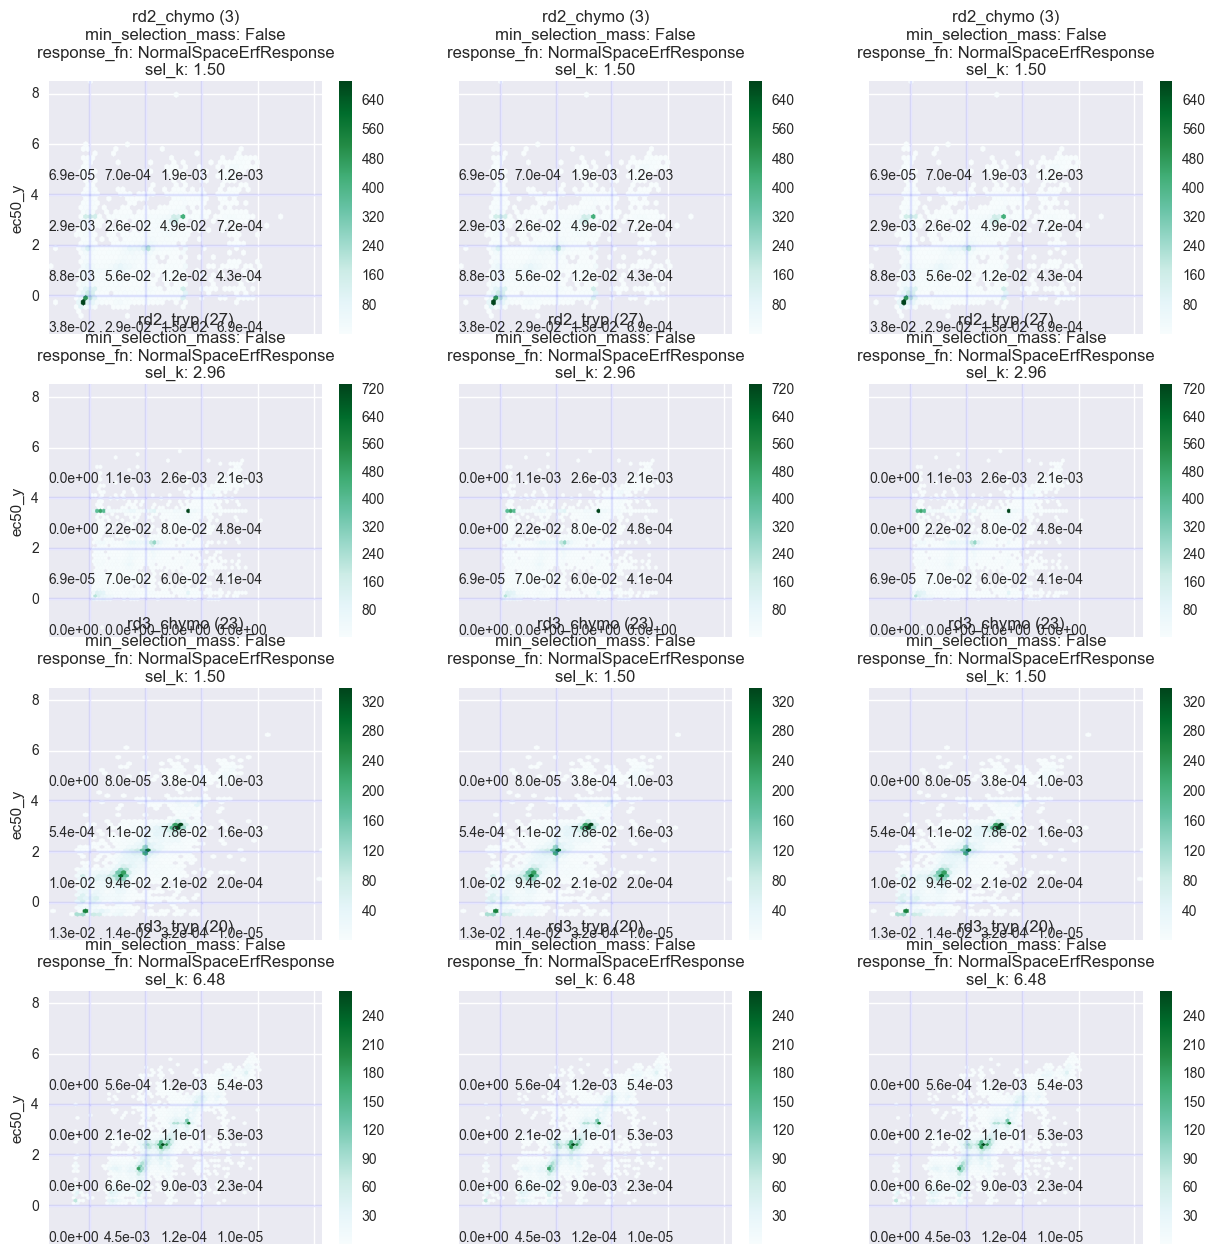

In [20]:
msm_lookup = {str(m) : m for m in list(set(eval_records["min_selection_mass"]))}
@ipyw.interact
def display_records_by_param(
    c1 = msm_lookup.keys(),
    c2 = msm_lookup.keys(),
    c3 = msm_lookup.keys(),
):
    
    c1 = msm_lookup[c1]
    c2 = msm_lookup[c2]
    c3 = msm_lookup[c3]
    
    r1 = eval_records[eval_records["min_selection_mass"] == c1].sort_values("dataset")
    r2 = eval_records[eval_records["min_selection_mass"] == c2].sort_values("dataset")
    r3 = eval_records[eval_records["min_selection_mass"] == c3].sort_values("dataset")
    
    f, axs = pylab.subplots(len(r1), 3, squeeze=True, figsize=(15, 15), sharex=True, sharey=True)
    
    for (ax1, ax2, ax3), (i1, i2, i3) in zip(axs, zip(r1.index, r2.index, r3.index)):
        plot_eval_pair(ax1, i1)
        plot_eval_pair(ax2, i2)
        plot_eval_pair(ax3, i3)